In [4]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt


In [5]:
# RUTA DEL DATASET (ajusta si hace falta)
DATA_PATH = Path("../data/interim/aprehendidos_detenidos/aprehendidos_limpio_final.csv")

# SALIDAS (opcional)
OUT_DIR = Path("../data/processed/aprehendidos_clustering")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Delitos que te interesan (tal cual los diste)
delitos_interes = [
    'DELITOS CONTRA EL DERECHO A LA PROPIEDAD',
    'DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN',
    'DELITOS CONTRA LA SEGURIDAD PÚBLICA',
    'DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRACIÓN PÚBLICA',
    'DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBROS DEL NÚCLEO FAMILIAR'
]


In [6]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(61149, 19)


C:\Users\User\AppData\Local\Temp\ipykernel_31696\148361422.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,fecha_completa,fecha,latitud,longitud,codigo_parroquia,nombre_parroquia,presunta_infraccion,tipo,arma,movilizacion,franja_horaria,dia,mes,dia_semana,lat_grid,lon_grid,conteo_delitos,es_delito_grave,conteo_delitos_graves
0,2025-02-03 08:00:00,2025-02-03,-3.715507,-79.618370,071150,PORTOVELO,BOLETAS,DETENIDO,NINGUNA,A PIE,8,3,2,0,-3.716,-79.618,1,0,0.0
1,2025-05-16 13:40:00,2025-05-16,-1.046660,-77.742967,150155,PUERTO MISAHUALLI,DELITOS CONTRA LOS RECURSOS MINEROS,APREHENDIDO,NINGUNA,SE_DESCONOCE,13,16,5,4,-1.047,-77.743,2,0,0.0
2,2025-05-20 13:30:00,2025-05-20,-2.260877,-79.878447,090150,GUAYAQUIL-FLORESTA,BOLETAS,DETENIDO,NINGUNA,A PIE,13,20,5,1,-2.261,-79.878,1,0,0.0
3,2025-04-11 17:00:00,2025-04-11,-3.270166,-79.953237,070150,MACHALA,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,DETENIDO,NINGUNA,A PIE,17,11,4,4,-3.270,-79.953,1,1,1.0
4,2025-09-18 15:30:00,2025-09-18,-0.951131,-79.358865,121150,VALENCIA,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,APREHENDIDO,NINGUNA,A PIE,15,18,9,3,-0.951,-79.359,1,1,1.0


In [7]:
# Asegurar tipos y columnas clave
required_cols = [
    "lat_grid", "lon_grid",
    "conteo_delitos", "conteo_delitos_graves",
    "presunta_infraccion"
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# Normalizar texto de presunta_infraccion
df["presunta_infraccion"] = (
    df["presunta_infraccion"]
    .astype(str)
    .str.upper()
    .str.strip()
)

# Flag: delito de interés
df["es_delito_interes"] = df["presunta_infraccion"].isin(delitos_interes)

# Asegurar numéricos
df["conteo_delitos"] = pd.to_numeric(df["conteo_delitos"], errors="coerce").fillna(0).astype(int)
df["conteo_delitos_graves"] = pd.to_numeric(df["conteo_delitos_graves"], errors="coerce").fillna(0).astype(int)

# Limpieza de grid
df = df.dropna(subset=["lat_grid", "lon_grid"])


In [8]:
group_keys = ["lat_grid", "lon_grid"]  # riesgo estructural por celda

df_riesgo = (
    df.groupby(group_keys)
      .agg(
          total_delitos=("conteo_delitos", "sum"),
          total_graves=("conteo_delitos_graves", "sum"),
          n_registros=("conteo_delitos", "size"),
      )
      .reset_index()
)

# Ratio severidad
df_riesgo["ratio_graves"] = df_riesgo["total_graves"] / df_riesgo["total_delitos"].clip(lower=1)

df_riesgo.describe()


,lat_grid,lon_grid,total_delitos,total_graves,n_registros,ratio_graves
count,33819.000000,33819.000000,33819.000000,33819.000000,33819.000000,33819.000000
mean,-1.386930,-79.181706,3.236731,1.827996,1.808126,0.479568
std,1.274908,1.473330,21.806785,18.520895,2.628145,0.477626
min,-4.978000,-90.983000,1.000000,0.000000,1.000000,0.000000
25%,-2.216000,-79.896000,1.000000,0.000000,1.000000,0.000000
50%,-1.294000,-79.210000,1.000000,1.000000,1.000000,0.500000
75%,-0.262000,-78.513000,2.000000,1.000000,2.000000,1.000000
max,2.088000,79.914000,2704.000000,2704.000000,147.000000,1.000000


In [9]:
features_riesgo = ["total_delitos", "ratio_graves", "n_registros"]

X = df_riesgo[features_riesgo].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_candidates = [2, 3, 4, 5, 6]
scores = []

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    scores.append((k, sil, dbi))

scores_df = pd.DataFrame(scores, columns=["k", "silhouette", "davies_bouldin"]).sort_values("k")
scores_df


,k,silhouette,davies_bouldin
0,2,0.959593,0.768622
1,3,0.734528,0.749812
2,4,0.742450,0.548073
3,5,0.767332,0.620559
4,6,0.773556,0.796028


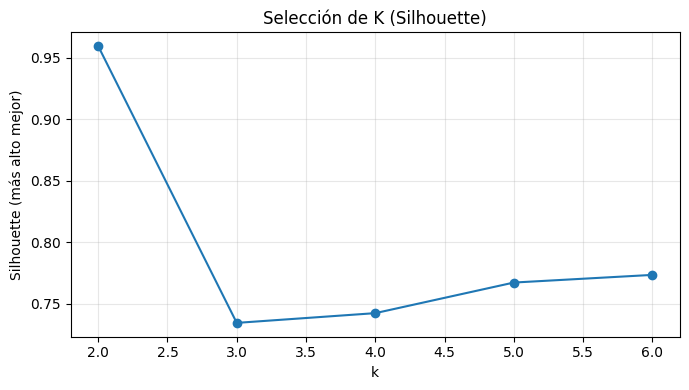

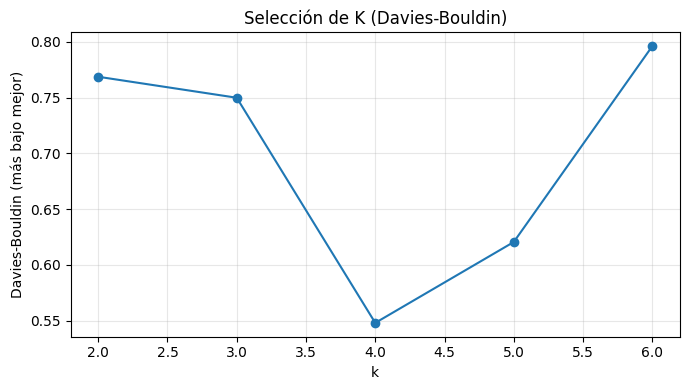

In [10]:
plt.figure(figsize=(7,4))
plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (más alto mejor)")
plt.title("Selección de K (Silhouette)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (más bajo mejor)")
plt.title("Selección de K (Davies-Bouldin)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
K = 3

kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
df_riesgo["cluster_id"] = kmeans.fit_predict(X_scaled)

df_riesgo["cluster_id"].value_counts().sort_index()


cluster_id
0    15511
1    18280
2       28
Name: count, dtype: int64

In [12]:
cluster_stats = (
    df_riesgo.groupby("cluster_id")
    .agg(
        mean_total_delitos=("total_delitos", "mean"),
        mean_ratio_graves=("ratio_graves", "mean"),
        mean_total_graves=("total_graves", "mean"),
        n=("cluster_id", "size")
    )
    .reset_index()
)

cluster_stats = cluster_stats.sort_values(
    ["mean_ratio_graves", "mean_total_delitos"],
    ascending=[True, True]
)

cluster_stats


,cluster_id,mean_total_delitos,mean_ratio_graves,mean_total_graves,n
1,1,2.369639,0.052864,0.180908,18280
2,2,428.285714,0.319141,235.821429,28
0,0,3.491329,0.982736,3.346722,15511


In [13]:
# Orden: menor riesgo -> mayor riesgo
ordered_clusters = cluster_stats["cluster_id"].tolist()

risk_map = {}
if len(ordered_clusters) == 3:
    risk_map[ordered_clusters[0]] = "BAJO"
    risk_map[ordered_clusters[1]] = "MEDIO"
    risk_map[ordered_clusters[2]] = "ALTO"
else:
    # Si usas otro K, asigna por cuantiles o etiqueta "NIVEL_i"
    for i, cid in enumerate(ordered_clusters):
        risk_map[cid] = f"NIVEL_{i+1}"

df_riesgo["nivel_riesgo"] = df_riesgo["cluster_id"].map(risk_map)
df_riesgo[["cluster_id", "nivel_riesgo"]].drop_duplicates().sort_values("cluster_id")


,cluster_id,nivel_riesgo
0,0,ALTO
3,1,BAJO
5303,2,MEDIO


In [14]:
df_clustered = df.merge(
    df_riesgo[group_keys + ["cluster_id", "nivel_riesgo"]],
    on=group_keys,
    how="left"
)

df_clustered[["cluster_id", "nivel_riesgo"]].isna().mean()


cluster_id      0.0
nivel_riesgo    0.0
dtype: float64

In [15]:
perfil_infracciones = (
    df_clustered[df_clustered["es_delito_interes"]]
    .groupby(["cluster_id", "nivel_riesgo", "presunta_infraccion"])
    .size()
    .reset_index(name="conteo")
)

perfil_infracciones["pct"] = (
    perfil_infracciones
    .groupby(["cluster_id"])["conteo"]
    .transform(lambda x: x / x.sum())
)

perfil_infracciones.sort_values(["cluster_id", "pct"], ascending=[True, False]).head(20)


,cluster_id,nivel_riesgo,presunta_infraccion,conteo,pct
0,0,ALTO,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,9378,0.349899
4,0,ALTO,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,8330,0.310798
2,0,ALTO,DELITOS CONTRA LA SEGURIDAD PÚBLICA,4806,0.179315
3,0,ALTO,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,2437,0.090926
1,0,ALTO,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,1851,0.069062
5,1,BAJO,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,1185,0.402240
9,1,BAJO,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,674,0.228785
8,1,BAJO,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,438,0.148676
6,1,BAJO,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,340,0.115411
7,1,BAJO,DELITOS CONTRA LA SEGURIDAD PÚBLICA,309,0.104888


In [16]:
TOP_N = 10

for cid in sorted(df_riesgo["cluster_id"].unique()):
    nivel = df_riesgo.loc[df_riesgo["cluster_id"] == cid, "nivel_riesgo"].iloc[0]
    print(f"\n=== Cluster {cid} | Riesgo: {nivel} ===")
    
    sub = (
        perfil_infracciones[perfil_infracciones["cluster_id"] == cid]
        .sort_values("pct", ascending=False)
        .head(TOP_N)
    )
    if len(sub) == 0:
        print("Sin registros de delitos_interes en este cluster.")
    else:
        display(sub[["presunta_infraccion", "conteo", "pct"]])



=== Cluster 0 | Riesgo: ALTO ===


,presunta_infraccion,conteo,pct
0,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,9378,0.349899
4,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,8330,0.310798
2,DELITOS CONTRA LA SEGURIDAD PÚBLICA,4806,0.179315
3,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,2437,0.090926
1,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,1851,0.069062



=== Cluster 1 | Riesgo: BAJO ===


,presunta_infraccion,conteo,pct
5,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,1185,0.402240
9,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,674,0.228785
8,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,438,0.148676
6,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,340,0.115411
7,DELITOS CONTRA LA SEGURIDAD PÚBLICA,309,0.104888



=== Cluster 2 | Riesgo: MEDIO ===


,presunta_infraccion,conteo,pct
10,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,164,0.386792
14,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,135,0.318396
12,DELITOS CONTRA LA SEGURIDAD PÚBLICA,62,0.146226
11,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,54,0.127358
13,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,9,0.021226


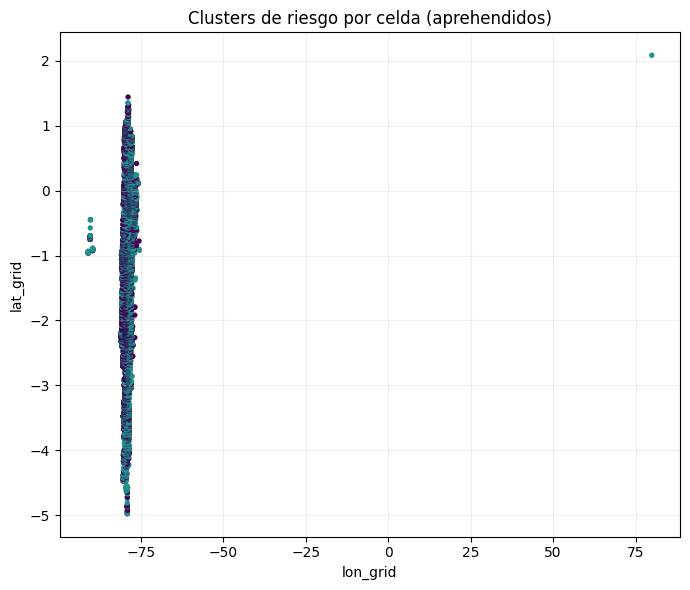

In [17]:
plt.figure(figsize=(7,6))
plt.scatter(df_riesgo["lon_grid"], df_riesgo["lat_grid"], c=df_riesgo["cluster_id"], s=8)
plt.xlabel("lon_grid")
plt.ylabel("lat_grid")
plt.title("Clusters de riesgo por celda (aprehendidos)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


In [18]:
out_cells = OUT_DIR / "riesgo_celdas_aprehendidos.csv"
df_riesgo.to_csv(out_cells, index=False, encoding="utf-8")
print("Guardado:", out_cells)


Guardado: ..\data\processed\aprehendidos_clustering\riesgo_celdas_aprehendidos.csv


In [19]:
out_profile = OUT_DIR / "perfil_infracciones_por_cluster.csv"
perfil_infracciones.to_csv(out_profile, index=False, encoding="utf-8")
print("Guardado:", out_profile)


Guardado: ..\data\processed\aprehendidos_clustering\perfil_infracciones_por_cluster.csv


In [20]:
out_full = OUT_DIR / "aprehendidos_con_cluster_y_riesgo.csv"
df_clustered.to_csv(out_full, index=False, encoding="utf-8")
print("Guardado:", out_full)


Guardado: ..\data\processed\aprehendidos_clustering\aprehendidos_con_cluster_y_riesgo.csv
